# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

-------------------------------------------------

# Решение

## Постановка задачи

Стоит задача предсказать значение (свойство) на основе набора признаков у ряда объектов.    
Для решения этой задачи используем модель регрессию.   
В качестве функции потерь берем MSE.    
Меру качества модели, которую будем оценивать с помощью валидационной выборки берём ту же, что и для обучения - MSE.    
Реализуем цикл оптимизации параметров следующим образом:   
1. Выбираем начальное значение весов(theta)  
2. Используем данное значение весов, чтобы найти y_pred   
3. Находим градиент функции потерь в пространстве коэффициентов, как градиент сложной функции, с помощью y_pred и y_test, в две итерации:
    * градиент линейной регрессии
    * градиент собственно функции потерь
4. Меняем веса в соответсвии со значением градиента. Скорость изменения регулируется с помощью значения alpha - шага, меньше либо равного 1.
5. Переходим к шагу 2, пока не пройдёт заданное количество циклов.

## Препроцессинг

In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
#%matplotlib inline

In [3]:
import seaborn as sns
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [6]:
Xtr = np.load('./X_train.npy')
ytr = np.load('./y_train.npy')

Для начала стоит понять, что за данные, с которыми мы будем работать, каковы их распределения, какую размерность они имеют и коррелируют ли между собой. Для этого воспользуемся инструментарием seaplot и построим гистограммы. 

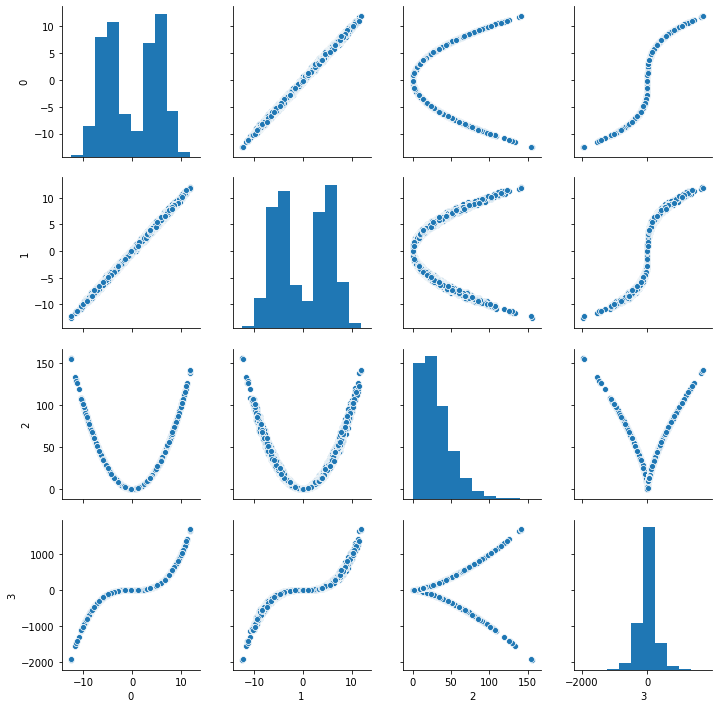

In [7]:
sns.pairplot(pd.DataFrame(Xtr))

Уже визуально можно отметить, что второй признак дублирует первый, чтобы удостовериться в этом построим матрицу корреляций:

In [8]:
np.corrcoef(Xtr.T)

array([[1.        , 0.99930832, 0.00924955, 0.88100664],
       [0.99930832, 1.        , 0.0096915 , 0.88030952],
       [0.00924955, 0.0096915 , 1.        , 0.01899396],
       [0.88100664, 0.88030952, 0.01899396, 1.        ]])

Видно, что второй признак очень сильно скореллирован с первым, таким образом, он не несет в себе много новой информации и мы можем его отбросить.

In [9]:
Xtr=np.delete(Xtr.T, [1],axis = 0).T

Проверим объекты на наличие избыточных, дублирующих элементов      
Наличие данных элементов может помешать работе алгоритма, если в одну из выборок попадёт много похожих элементов, а в другой их не будет.

In [48]:
#проверка на лишние объекты
pd.DataFrame(np.concatenate((Xtr, ytr), axis=1).round(2)).drop_duplicates()

,0,1,2,3
0,-1.38,1.90,-2.63,2.47
1,-5.41,29.29,-158.48,10.00
2,-4.30,18.49,-79.50,9.28
3,-6.01,36.06,-216.56,8.63
4,-6.42,41.22,-264.65,9.57
5,-4.24,17.96,-76.12,8.30
6,-5.45,29.65,-161.45,11.06
7,-6.27,39.26,-246.03,10.75
8,-0.39,0.15,-0.06,0.10
9,-6.78,46.02,-312.15,7.87


Видим, что все элементы уникальны, значит ничего удалять не имеет смысла.

-------------------------------------------------------------

Для оценки результатов работы модели разобъем выборку на обучающую (train) и валидационную (test)    

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(Xtr, ytr, test_size=0.2, shuffle = True, random_state=42)

Приведем данные к нормальному виду с мат.ожиданием 0 и дисперсией 1 (как можно увидеть из гистограмм выше, на текущий момент данные имеют крайне разную размерность)

In [12]:
sc = StandardScaler()
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)

Важно, что для нормировки мы фитимся на данные исключительно из `train`, потому что на стадии обучения информации о `test` у нас ещё нет.    

На стадии препроцессинга добавим к матрице объектов-признаков столбец единиц, который будет отвечать за свободный член в линейной регрессии.   
Это можно сделать как вручную:

In [13]:
#Xtr = np.c_[ Xtr, np.ones(len(Xtr)) ]

Так и с помощью `PolynomialFeatures` с выставленным значением `include_bias=True`

In [14]:
model = PolynomialFeatures(degree=1, include_bias=True)

xtrain = model.fit_transform(xtrain)
xtest = model.fit_transform(xtest)

`PolynomialFeatures` также можно использовать для увеличения признакового пространства, образуя признаки из уже существующих, возводя их в степень и перемножая между собой.    

## Реализация алгоритма

In [15]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):

        raise NotImplementedError()

In [16]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()
    
    def forward(self, y_pred, y_true):
        # Этот метод реализует вычисление значения функции потерь
        # Подсказка: метод должен возвращать единственный скаляр - значение функции потерь
        #реализовать нормировку на длину y
        ### YOUR CODE HERE
        loss_value = sum((y_pred - y_true)**2)/len(y_pred)
                
        return loss_value
    
    
    def backward(self, y_pred, y_true):
        # Этот метод реализует вычисление градиента функции потерь по аргументу y_pred
        # Подсказка: метод должен возвращать вектор градиента функции потерь
        #           размерностью, совпадающей с размерностью аргумента y_pred       
        ### YOUR CODE HERE
        partial_grad = 2*(y_pred-y_true)/len(y_pred)
        
        return partial_grad

In [17]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)
    
    def backward(self, X):
        # Этот метод реализует вычисление компоненты градиента функции потерь    
        ### YOUR CODE HERE
        partial_grad = X
        
        return partial_grad
    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        
        if (self.theta is None):
            # Если вектор параметров еще не инициализирован, его следует инициализировать
            # Подсказка: длина вектора параметров может быть получена из размера матрицы X
            ### YOUR CODE HERE
            #self.theta = np.zeros((X.shape[-1], 1))
            self.theta = np.random.randn(X.shape[-1]).reshape(X.shape[-1],1) + 1
        
        
        # Здесь следует собственно применить модель к входным данным
        # Подсказка: удобно расширить матрицу X дополнительным признаком,
        #            чтобы применять матричные операции, очень эффективно реализованные в numpy
        ### YOUR CODE HERE
        y_pred = X@self.theta
        
        return y_pred

В рамках работы внутрь цикла был добавлен подсчёт не только функции потерь обучающей выборки, которая нужна для визуализации процесса обучения, но и функции потерь на валидационной выборке.    
Обучение на валидационной выборке не ведётся, но постоянное сравнение с ней может дать нам понять, в какой момент начнётся переобучение (в то время, как функция потерь на тестовой выборке всегда падает, функция потерь на валидации может начать расти после некоторого поколения, это и будет обозначать переобучение)

In [18]:
def train_loop(xtrain, ytrain, xtest, ytest, model, loss_fn, epochs=100):
    loss_history = []
    loss_validation_history = []
    pbar = tqdm(total=epochs)
    alpha=1e-1
    for epoch in range(epochs):
        # В этом цикле следует реализовать итеративную процедуру оптимизации параметров модели model,
        #        руководствуясь функцией потерь loss_fn
        
        ### YOUR CODE HERE
        loss_value = loss_fn.forward(model.forward(xtrain), ytrain)
        loss_validation_value = loss_fn.forward(model.forward(xtest), ytest)
        grad = model.backward(xtrain).T @ loss_fn.backward(model.forward(xtrain), ytrain)
        model.theta = model.theta - alpha*grad

        
        loss_history.append(loss_value)
        loss_validation_history.append(loss_validation_value)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value, 'loss_validation': loss_validation_value})
    pbar.close()
    return loss_history, loss_validation_history, model.theta

In [19]:
obj_fn = loss()
lr_model = linear_regression()
loss_history, loss_validation_history, weights = train_loop(xtrain, ytrain, 
                                                            xtest, ytest, lr_model, obj_fn, epochs=300)

100%|██████████| 300/300 [00:23<00:00, 12.93it/s, loss=[0.52515092], loss_validation=[0.54068536]]  


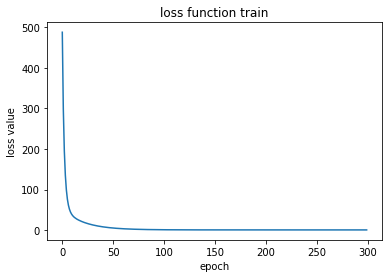

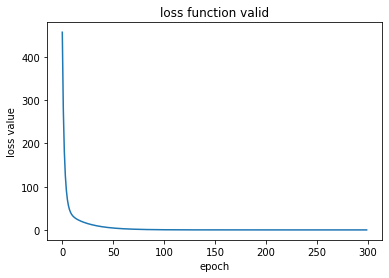

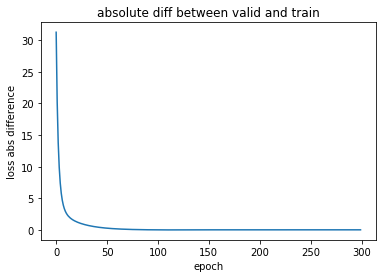

In [62]:
plt.plot(loss_history)
plt.title('loss function train')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()
plt.plot(loss_validation_history)
plt.title('loss function valid')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()
plt.plot(abs(np.array(loss_history) - np.array(loss_validation_history)))
plt.title('absolute diff between valid and train')
plt.xlabel('epoch')
plt.ylabel('loss abs difference')
plt.show()

Видно, что в ходе работы линейной регрессии, алгоритм экспоненциально быстро достигает высокой точности, при этом переобучение не наблюдается, ошибка на test ни в какой момент не начинает расти.

## Анализ результатов

Чтобы проверить правильность реализованного нами алгоритма, можно обратиться непосредственно к градиентному спуску, реализованному в sklearn. Проверим точность с нашими данными на нём.

In [49]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

In [50]:
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-1))

In [51]:
reg.fit(xtrain, ytrain.T[0])
y_pred = reg.predict(xtest)
y_pred = np.array([y_pred])

In [52]:
sum((np.array(y_pred[0]) - np.array(ytest.T[0]))**2)/len(ytest)

0.5416836808422626

In [60]:
expect_val=0
for i in range (len(ytest)):
    expect_val+=ytest[i]
expect_val = expect_val/len(ytest)
expect_val[0]

14.409094853138177

* Видно, что результат предсказания, полученный в ходе работы stochastic gradient descent совпадает с результатом алгоритма, реализованным нами, с точностью до **3** знака. Таким образом нашу реализацию можно считать успешной.    
* При этом полученную точность можно субъективно считать высокой, **MSE = 0.54** при матожидании около **14.4**.    
* Таким образом, можно считать модель линейной регрессии удачной для решения данной задачи.    
* Входные данные обладали одним лишним признаком, и не имели дублирующих, лишних объектов внутри себя.  
* Анализируя поведение функции потерь на выборках, можно сделать вывод, что **300** поколений хватает для обучения модели, недообучение и переобучение не наблюдается (также, если увеличить число поколений до **1000**, переобучения так же не будет, однако loss function будет меняться слабо, тч смысл в этом есть, только если уменьшать шаг (alpha). Это потенциально должно дать ещё более высокую точность, но я в данном случае удовлетворён уже полученным качеством.)
* Также можно отметить, что всё ещё остаётся возможность использовать `PolynomialFeatures` для расширения признакового пространства, и потенциального улучшения резальтата, однако, как сказано ранее, я считаю полученную точность достаточно высокой.